In [ ]:
import torch 
import torch.optim as optim 
import numpy as np 
import pandas as pd
import random 
from tqdm import tqdm 
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sklearn.metrics import classification_report

def set_seeds(seed):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
set_seeds(0)

## Load file

In [2]:
new_df = pd.read_csv('final-data-updated.csv', encoding='utf-8-sig')
new_df = new_df.dropna(subset=['Sentiment'])

dataset = load_dataset('financial_phrasebank', 'sentences_50agree')
train_dataset = dataset['train']

# Extract data from Hugging Face
huggingface_x = train_dataset['sentence']
huggingface_y = train_dataset['label']

# Extract columns from our dataset
new_x = new_df['Summary'].tolist()
new_y = new_df['Sentiment'].tolist()

# Split dataset into train and test sets
x_train, x_valid, y_train, y_valid = train_test_split(huggingface_x, huggingface_y, test_size=0.2, random_state=42)
x_train += new_x
y_train += new_y

print("Trainset:", len(x_train))
print("Validset:", len(x_valid))

Trainset: 6152
Validset: 970


## Create dataset

In [3]:
# Convert to Pytorch format
class News(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

          
    def __getitem__(self, index):
        return self.x[index], self.y[index]
       
    def __len__(self):
        return len(self.x)
    
trainset = News(x_train, y_train)
validset = News(x_valid, y_valid)

In [4]:

def collate_fn(batch):  
    # Batch retrieval
    (x, y) = zip(*batch)
    # Tokenise  x into tesnor (datatype = float)
    x = tokenizer(x, max_length=512, truncation=True, padding="longest", return_tensors='pt') 
    # Preparing labels (datatype = int)
    y = {'labels': torch.LongTensor(y)}
    return {**x, **y}

# Initial tokenizer 
tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-yelp-polarity")
# Set up a DataLoader for the training dataset
train_loader = DataLoader(trainset, batch_size = 16, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=collate_fn)
# Set up a DataLoader for the testing dataset
valid_loader = DataLoader(validset, batch_size = 16, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=collate_fn)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Model initialisation for sequence classification task with three output labels
model = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-yelp-polarity", num_labels = 3, ignore_mismatched_sizes=True)
model.to(device)
# AdamW optimizer -> adjusting weights
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at textattack/bert-base-uncased-yelp-polarity and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def train(epoch):
    train_loss, train_acc = 0, 0
    train_pbar = tqdm(train_loader, position=0, leave=True) 
    
    model.train() # switch to train mode
    for input_datas in train_pbar: 
        for key in input_datas.keys():
            input_datas[key] = input_datas[key].to(device)
        optimizer.zero_grad()  # grad -> 0 to prevent gradient from accumulating
        outputs = model(**input_datas) # forward propagation
        
        logits = outputs.logits
        loss = outputs.loss

        loss.backward() # backpropogation
        optimizer.step() # update weight
        
        train_pbar.set_description(f'Train Epoch {epoch}')  
        train_pbar.set_postfix({'loss':f'{loss:.3f}'}) # show current loss
        
        pred = torch.argmax(logits, dim = 1)
        train_acc += sum(pred == input_datas['labels']) 
        train_loss += loss.item()  # save information of loss
    return train_loss/len(train_loader), train_acc/len(trainset) # loss & accuracy


def valid(epoch):
    valid_loss, valid_acc = 0, 0
    valid_pbar = tqdm(valid_loader, position=0, leave=True)
    y_preds, y_trues = [], []
    model.eval()
    with torch.no_grad(): 
        for input_datas in valid_pbar:
            for key in input_datas.keys():
                input_datas[key] = input_datas[key].to(device)
            
            outputs = model(**input_datas)
            logits = outputs.logits
            loss = outputs.loss
            
            valid_pbar.set_description(f'Valid Epoch {epoch}')
            valid_pbar.set_postfix({'loss':f'{loss:.3f}'})

            pred = torch.argmax(logits, dim = 1)
            valid_acc += sum(pred == input_datas['labels'])
            valid_loss += loss.item()

            y_trues.extend(input_datas['labels'].cpu())
            y_preds.extend(pred.cpu())

    print(classification_report(y_trues, y_preds))

    return valid_loss/len(valid_loader), valid_acc/len(validset)


# Function for plotting the result of loss   
def show_training_loss(loss_record):
    train_loss, valid_loss = [i for i in loss_record.values()]
    
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.title('Result')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_13260\358987072.py:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 0: 100%|██████████| 61/61 [00:01<00:00, 42.97it/s, loss=0.357]


              precision    recall  f1-score   support

           0       0.45      0.45      0.45       110
           1       0.83      0.84      0.83       571
           2       0.51      0.49      0.50       289

    accuracy                           0.69       970
   macro avg       0.59      0.59      0.59       970
weighted avg       0.69      0.69      0.69       970

Saving Model With Acc 0.69072
Train Loss: 0.85537 Train Acc: 0.60647| Valid Loss: 0.70618 Valid Acc: 0.69072| Best Acc: 0.69072



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_13260\358987072.py:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 1: 100%|██████████| 61/61 [00:01<00:00, 44.23it/s, loss=0.720]


              precision    recall  f1-score   support

           0       0.58      0.87      0.70       110
           1       0.89      0.79      0.84       571
           2       0.69      0.72      0.71       289

    accuracy                           0.78       970
   macro avg       0.72      0.79      0.75       970
weighted avg       0.80      0.78      0.78       970

Saving Model With Acc 0.77732
Train Loss: 0.61331 Train Acc: 0.75894| Valid Loss: 0.60060 Valid Acc: 0.77732| Best Acc: 0.77732



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_13260\358987072.py:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 2: 100%|██████████| 61/61 [00:01<00:00, 44.03it/s, loss=0.428]


              precision    recall  f1-score   support

           0       0.80      0.65      0.71       110
           1       0.88      0.87      0.87       571
           2       0.74      0.80      0.77       289

    accuracy                           0.82       970
   macro avg       0.80      0.77      0.79       970
weighted avg       0.83      0.82      0.82       970

Saving Model With Acc 0.82474
Train Loss: 0.44906 Train Acc: 0.84330| Valid Loss: 0.52704 Valid Acc: 0.82474| Best Acc: 0.82474



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_13260\358987072.py:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 3: 100%|██████████| 61/61 [00:01<00:00, 43.15it/s, loss=0.132]


              precision    recall  f1-score   support

           0       0.75      0.75      0.75       110
           1       0.90      0.84      0.87       571
           2       0.74      0.83      0.79       289

    accuracy                           0.83       970
   macro avg       0.80      0.81      0.80       970
weighted avg       0.83      0.83      0.83       970

Saving Model With Acc 0.82784
Train Loss: 0.33769 Train Acc: 0.88410| Valid Loss: 0.47212 Valid Acc: 0.82784| Best Acc: 0.82784



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_13260\358987072.py:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 4: 100%|██████████| 61/61 [00:01<00:00, 43.72it/s, loss=0.441]


              precision    recall  f1-score   support

           0       0.76      0.76      0.76       110
           1       0.88      0.85      0.87       571
           2       0.74      0.79      0.77       289

    accuracy                           0.82       970
   macro avg       0.80      0.80      0.80       970
weighted avg       0.83      0.82      0.82       970

Train Loss: 0.20574 Train Acc: 0.93449| Valid Loss: 0.59496 Valid Acc: 0.82371| Best Acc: 0.82784



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_13260\358987072.py:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 5: 100%|██████████| 61/61 [00:01<00:00, 44.11it/s, loss=0.707]


              precision    recall  f1-score   support

           0       0.92      0.60      0.73       110
           1       0.87      0.88      0.87       571
           2       0.71      0.80      0.75       289

    accuracy                           0.82       970
   macro avg       0.83      0.76      0.78       970
weighted avg       0.83      0.82      0.82       970

Train Loss: 0.13911 Train Acc: 0.96099| Valid Loss: 0.58043 Valid Acc: 0.82062| Best Acc: 0.82784



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_13260\358987072.py:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 6: 100%|██████████| 61/61 [00:01<00:00, 43.86it/s, loss=0.502]


              precision    recall  f1-score   support

           0       0.72      0.76      0.74       110
           1       0.85      0.92      0.88       571
           2       0.85      0.69      0.76       289

    accuracy                           0.83       970
   macro avg       0.81      0.79      0.80       970
weighted avg       0.84      0.83      0.83       970

Saving Model With Acc 0.83402
Train Loss: 0.13394 Train Acc: 0.95806| Valid Loss: 0.76638 Valid Acc: 0.83402| Best Acc: 0.83402



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_13260\358987072.py:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 7: 100%|██████████| 61/61 [00:01<00:00, 42.62it/s, loss=2.213]


              precision    recall  f1-score   support

           0       0.79      0.74      0.76       110
           1       0.83      0.90      0.87       571
           2       0.81      0.70      0.75       289

    accuracy                           0.82       970
   macro avg       0.81      0.78      0.79       970
weighted avg       0.82      0.82      0.82       970

Train Loss: 0.10150 Train Acc: 0.96765| Valid Loss: 0.81365 Valid Acc: 0.82268| Best Acc: 0.83402



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_13260\358987072.py:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 8: 100%|██████████| 61/61 [00:01<00:00, 42.76it/s, loss=0.391]


              precision    recall  f1-score   support

           0       0.51      0.91      0.65       110
           1       0.92      0.70      0.79       571
           2       0.70      0.83      0.76       289

    accuracy                           0.76       970
   macro avg       0.71      0.81      0.73       970
weighted avg       0.81      0.76      0.77       970

Train Loss: 0.09246 Train Acc: 0.97513| Valid Loss: 0.89938 Valid Acc: 0.75979| Best Acc: 0.83402



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_13260\358987072.py:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 9: 100%|██████████| 61/61 [00:01<00:00, 44.15it/s, loss=1.463]


              precision    recall  f1-score   support

           0       0.76      0.85      0.80       110
           1       0.87      0.87      0.87       571
           2       0.80      0.77      0.78       289

    accuracy                           0.84       970
   macro avg       0.81      0.83      0.82       970
weighted avg       0.84      0.84      0.84       970

Saving Model With Acc 0.83814
Train Loss: 0.08495 Train Acc: 0.97432| Valid Loss: 0.62770 Valid Acc: 0.83814| Best Acc: 0.83814



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_13260\358987072.py:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 10: 100%|██████████| 61/61 [00:01<00:00, 43.76it/s, loss=0.329]


              precision    recall  f1-score   support

           0       0.89      0.57      0.70       110
           1       0.84      0.88      0.86       571
           2       0.75      0.79      0.77       289

    accuracy                           0.82       970
   macro avg       0.83      0.75      0.78       970
weighted avg       0.82      0.82      0.82       970

Train Loss: 0.05004 Train Acc: 0.98423| Valid Loss: 0.93201 Valid Acc: 0.81856| Best Acc: 0.83814



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_13260\358987072.py:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 11: 100%|██████████| 61/61 [00:01<00:00, 44.08it/s, loss=0.855]


              precision    recall  f1-score   support

           0       0.82      0.74      0.78       110
           1       0.87      0.85      0.86       571
           2       0.72      0.79      0.75       289

    accuracy                           0.82       970
   macro avg       0.80      0.79      0.80       970
weighted avg       0.82      0.82      0.82       970

Train Loss: 0.07500 Train Acc: 0.97903| Valid Loss: 0.71893 Valid Acc: 0.81753| Best Acc: 0.83814



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_13260\358987072.py:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 12: 100%|██████████| 61/61 [00:01<00:00, 43.85it/s, loss=0.006]


              precision    recall  f1-score   support

           0       0.84      0.74      0.79       110
           1       0.87      0.85      0.86       571
           2       0.73      0.81      0.77       289

    accuracy                           0.82       970
   macro avg       0.82      0.80      0.81       970
weighted avg       0.83      0.82      0.83       970

Train Loss: 0.04984 Train Acc: 0.98586| Valid Loss: 0.85105 Valid Acc: 0.82474| Best Acc: 0.83814



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_13260\358987072.py:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 13: 100%|██████████| 61/61 [00:01<00:00, 44.62it/s, loss=0.659]


              precision    recall  f1-score   support

           0       0.74      0.77      0.76       110
           1       0.86      0.88      0.87       571
           2       0.78      0.73      0.76       289

    accuracy                           0.82       970
   macro avg       0.79      0.79      0.79       970
weighted avg       0.82      0.82      0.82       970

------------------------------------
|Model can't improve, stop training|
------------------------------------


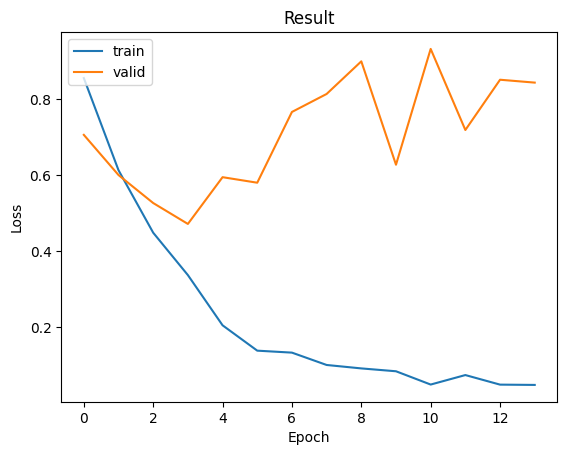

In [7]:
# Setting up hyperparameters
epochs = 20                              
early_stopping = 4                      
stop_cnt = 0                         
model_path = 'model.ckpt'                
show_loss = True                        
best_acc = 0                             
loss_record = {'train':[], 'valid':[]}   

for epoch in range(epochs):   
    train_loss, train_acc = train(epoch)
    valid_loss, valid_acc = valid(epoch)
    
    loss_record['train'].append(train_loss)
    loss_record['valid'].append(valid_loss)
    
    # save best weight
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print(f'Saving Model With Acc {best_acc:.5f}')
        stop_cnt = 0
    else:
        stop_cnt+=1
    
    # Early stopping
    if stop_cnt == early_stopping:
        output = "Model can't improve, stop training"
        print('-' * (len(output)+2))
        print(f'|{output}|')
        print('-' * (len(output)+2))
        break

    print(f'Train Loss: {train_loss:.5f} Train Acc: {train_acc:.5f}', end='| ')
    print(f'Valid Loss: {valid_loss:.5f} Valid Acc: {valid_acc:.5f}', end='| ')
    print(f'Best Acc: {best_acc:.5f}', end='\n\n')

if show_loss:
    show_training_loss(loss_record)
        